In [141]:
from random import random
from typing import Tuple

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import tensorflow as tf

% matplotlib inline

UsageError: Line magic function `%` not found.


## 데이터 준비

In [3]:
def split_seqeunce(sequence, step):
    """데이터셋용 시퀀스 분할.

    x, y = sequence[i:i + step], sequence[i + step]
    시퀀스의 일정 부분을 보고 그 다음엔 뭐가 올지 추측하는 모델을 위한 데이터셋 생성 헬퍼 함수.

    :param sequence: 분할 대상.
    :param step: 분할 크기.
    :return: 분할된 부분과 그 다음 원소의 슬라이스들.
    """
    x, y = [], []

    for i in range(len(sequence)):
        end_idx = i + step
        if end_idx > len(sequence) - 1:
            break
        x.append(sequence[i:end_idx])
        y.append(sequence[end_idx])

    return np.array(x), np.array(y)


def preprocess(dataset: np.ndarray, new_dim_size: int) -> np.ndarray:
    """RNN 레이어 입력 요구 사항을 맞추기 위한 전처리.

    :param dataset: ndim=2의 ndarray
    :param new_dim_size: 추가된 차원의 크기.
    :return: ndim = (ndim + 1)로 형태가 바뀐 ndarray
    """
    return dataset.reshape(*dataset.shape, new_dim_size)

In [4]:
x_ticks = 15  # RNN이 1회 추론에 입력 받게 될 데이터.
n_features = 1  # 전처리 단계와 출력층의 크기로서도 써먹는다.

In [5]:
x = np.arange(start=-10, stop=10, step=0.1)
dataset_y = np.sin(x)
dataset_x, dataset_y = split_seqeunce(dataset_y, x_ticks)

In [6]:
print(dataset_x.shape)  # shape: (len(x) / x_ticks, x_ticks)
print(dataset_y.shape)

(185, 15)
(185,)


In [7]:
# RNN 요구 shape(ndim=3)을 맞추기 위해 차원 추가.
dataset_x = preprocess(dataset_x, n_features)

## 모델 훈련

In [8]:
input_layer = keras.layers.Input(shape=dataset_x.shape[1:])
rnn_layer = keras.layers.SimpleRNN(
    units=10,
    return_sequences=False,
    input_shape=(x_ticks, n_features))(input_layer)
dense_layer = keras.layers.Dense(n_features)(rnn_layer)
rnn_model = keras.Model(inputs=input_layer, outputs=dense_layer)
rnn_model.compile(optimizer=keras.optimizers.legacy.Adam(), loss="mse")

Metal device set to: Apple M1 Pro


2023-01-18 04:25:06.057472: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-18 04:25:06.057503: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=5,
    mode="auto")
history = rnn_model.fit(dataset_x, dataset_y, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000


2023-01-18 04:25:06.689149: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-18 04:25:07.027192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 82ms/step - loss: 0.4203
Epoch 2/1000
6/6 [==============================] - 0s 83ms/step - loss: 0.2471
Epoch 3/1000
6/6 [==============================] - 0s 78ms/step - loss: 0.1465
Epoch 4/1000
6/6 [==============================] - 0s 76ms/step - loss: 0.0935
Epoch 5/1000
6/6 [==============================] - 0s 80ms/step - loss: 0.0611
Epoch 6/1000
6/6 [==============================] - 1s 82ms/step - loss: 0.0403
Epoch 7/1000
6/6 [==============================] - 0s 75ms/step - loss: 0.0259
Epoch 8/1000
6/6 [==============================] - 0s 75ms/step - loss: 0.0162
Epoch 9/1000
6/6 [==============================] - 0s 78ms/step - loss: 0.0113
Epoch 10/1000
6/6 [==============================] - 0s 77ms/step - loss: 0.0090
Epoch 11/1000
6/6 [==============================] - 0s 73ms/step - loss: 0.0078
Epoch 12/1000
6/6 [==============================] - 0s 77ms/step - loss: 0.0076
Epoch 13/1000
6/6 [==============================]

## 훈련 결과 확인

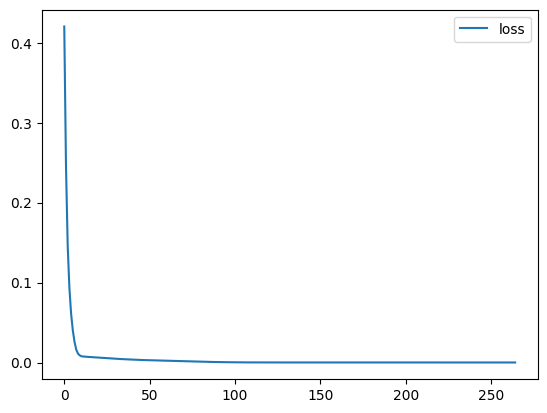

In [10]:
plt.plot(history.history["loss"], label="loss")
plt.legend(loc="upper right")
plt.show()

## 테스트셋 검증

In [11]:
x = np.arange(10, 20, 0.1)
y = np.cos(x)

In [12]:
test_x, test_y = split_seqeunce(y, x_ticks)
print(test_x.shape, test_y.shape)
# Preprocess
test_x = preprocess(test_x, n_features)

(85, 15) (85,)


In [13]:
pred_y = rnn_model.predict(test_x)

3/3 [==============================] - 0s 23ms/step


2023-01-18 04:27:05.517726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [14]:
# x[:x_ticks] 분만큼은 범위 문제로 테스트셋에선 예측할 수 없으니, 정답과 예측 그래프를 맞추기 위해
# 이 부분은 앞에 정답을 끼워넣는다.
len_fixed_pred_y = np.append(y[:x_ticks], pred_y)

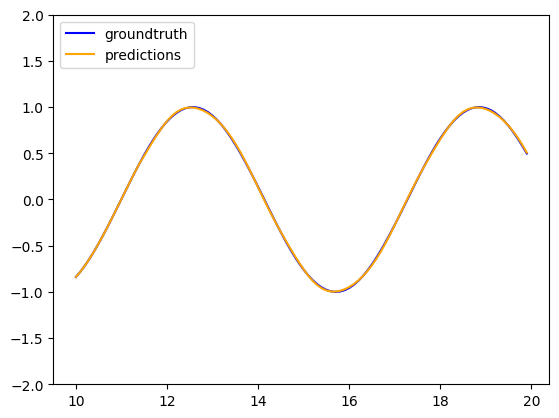

In [15]:
plt.plot(x, y, label="groundtruth", color="blue")
plt.plot(x, len_fixed_pred_y, label="predictions", color="orange")
plt.legend(loc="upper left")
plt.ylim(-2, 2)
plt.show()

# LSTM 모델 생성 및 예측

RNN 모델의 한계로는 시퀀스가 길어질수록 최근의 데이터 영향이 강하고, 시퀀스 앞쪽의 데이터의 영향은 약해지는
장기의존성(Long term dependency)이 생긴다는 점이다. 이를 해소하기 위한 모델 구조로 LSTM이 제안됐다.

Long-Short Term Model이란 이름에서 알 수 있듯, 단기 상태이던 은닉 상태(hidden state)에
장기 상태인 셀 상태(cell state)를 추가하여 RNN 모델의 단점을 해소했다. 이런 셀 상태를 계산하기 위해
'입력, 삭제, 출력 게이트'라는 3개의 게이트 모델에 도입했다.

LSTM에서 사용되는 활성화 함수는 두 가지다: sigmoid, tanh. 각각의 함수의 범위는 sig가 `[0, 1]`,
tanh가 `[-1, 1]`이다. 여기서 sig는 정보를 얼마나 약화시킬지 감쇠도를, tanh는 정보를 단기 상태 범위로
스케일을 축소시킨다.

  - 입력 게이트(input gate): 장기 상태에 추가할 정보량(수명)을 의미.
    - i_cur = sig(x_cur, h_prev)
    - g_cur = tanh(x_cur, h_prev)
  - 삭제 게이트(forget gate): 장기 상태를 얼마나 잊을지 감쇠도.
    - f_cur = sig(x_cur, h_prev)
  - 출력 게이트(output gate): 단기 상태를 얼마나 잊을지 감쇠도.
    - o_cur = sig(x_cur, h_prev)

  - 단기 상태: 이전 시점까지 끌고 온 장기적 정보(c_cur)를 단기적 정보 범위로 바꾼다.
    - h_cur = tanh(c_cur) * o_cur
  - 장기 상태: 이전 정보에 감쇠도를 적용 후, 이번 시점 정보를 추가한다.
    - c_cur = c_prev * f_cur + i_cur * g_cur


모델 구조만 RNN 레이어를 LSTM 레이어로 변경하면 된다.

In [16]:
lstm_layer = keras.layers.LSTM(
    units=10,
    return_sequences=False,
    input_shape=(x_ticks, n_features))(input_layer)
dense_layer = keras.layers.Dense(n_features)(lstm_layer)
lstm_model = keras.Model(inputs=input_layer, outputs=dense_layer)
lstm_model.compile(optimizer=keras.optimizers.legacy.Adam(), loss="mse")

In [17]:
history = lstm_model.fit(dataset_x, dataset_y, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000


2023-01-18 04:27:06.621273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 04:27:06.694631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 04:27:06.756752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 15ms/step - loss: 1.1009
Epoch 2/1000
6/6 [==============================] - 0s 9ms/step - loss: 1.0256
Epoch 3/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.9598
Epoch 4/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.8982
Epoch 5/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.8430
Epoch 6/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.7892
Epoch 7/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.7398
Epoch 8/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6925
Epoch 9/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6465
Epoch 10/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.6002
Epoch 11/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5559
Epoch 12/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.5091
Epoch 13/1000
6/6 [==============================] - 0s 9ms/s

In [18]:
pred_y = lstm_model.predict(test_x)

3/3 [==============================] - 0s 7ms/step


2023-01-18 04:27:18.604470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 04:27:18.629729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


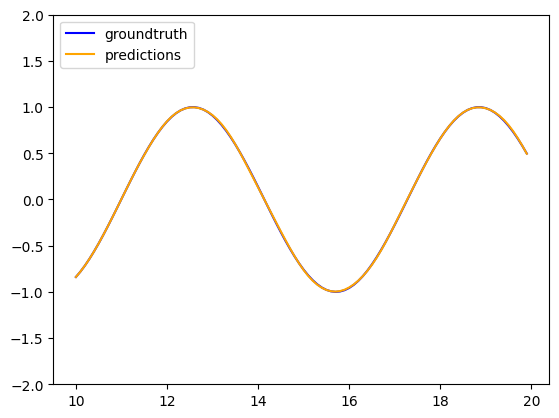

In [19]:
len_fixed_pred_y = np.append(y[:x_ticks], pred_y)
plt.plot(x, y, label="groundtruth", color="blue")
plt.plot(x, len_fixed_pred_y, label="predictions", color="orange")
plt.legend(loc="upper left")
plt.ylim(-2, 2)
plt.show()

# 양방향 LSTM(Bi-directional LSTM)
LSTM은 시퀀스 내 현재 시점을 오로지 이전 시점의 정보들로만 학습하고 추론한다는 한계가 있다.
이 문제를 해결코자 시퀀스 현재 시점 전후를 모두 읽어들이도록 확장한 LSTM이 양방향 LSTM이다.
간단하게 h_t = f(forward_lstm, backward_lstm) 정도로 표현할 수 있다.


In [28]:
def get_sequence(length: int) -> Tuple:
    x = np.array([random() for _ in range(length)])
    limit = length / 4.0
    y = np.array([0 if elem < limit else 1 for elem in np.cumsum(x)])

    # 양방향 LSTM 레이어에서 요구하는 형태(n_dim = 3)로 전처리.
    x = x.reshape(1, length, 1)
    y = y.reshape(1, length, 1)

    return x, y

In [60]:
n_units = 20
n_timestpes = 100

In [61]:
input_layer = keras.layers.Input(shape=(n_timestpes, 1))
bi_lstm_layer = keras.layers.Bidirectional(
    keras.layers.LSTM(units=n_units,
                      return_sequences=True))(input_layer)
dense_layer = keras.layers.TimeDistributed(
    keras.layers.Dense(1, activation="sigmoid"))(bi_lstm_layer)
bi_lstm_model = keras.Model(inputs=input_layer, outputs=dense_layer)

bi_lstm_model.compile(loss="binary_crossentropy",
                      optimizer=keras.optimizers.legacy.Adam(),
                      metrics=["accuracy"])

In [62]:
dataset_x, dataset_y = get_sequence(n_timestpes)
test_x, test_y = get_sequence(n_timestpes)

In [63]:
history = bi_lstm_model.fit(dataset_x, dataset_y, epochs=1000, callbacks=[early_stopping])

Epoch 1/1000


2023-01-18 04:48:03.326307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 04:48:03.467107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 04:48:03.479619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.6981 - accuracy: 0.4900
Epoch 2/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.6971 - accuracy: 0.4900
Epoch 3/1000


2023-01-18 04:48:03.641386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 04:48:03.657846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 42ms/step - loss: 0.6961 - accuracy: 0.4900
Epoch 4/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.6952 - accuracy: 0.4900
Epoch 5/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.6944 - accuracy: 0.4900
Epoch 6/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.6936 - accuracy: 0.4900
Epoch 7/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.6929 - accuracy: 0.4900
Epoch 8/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.6922 - accuracy: 0.4900
Epoch 9/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.6915 - accuracy: 0.4900
Epoch 10/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.6908 - accuracy: 0.4900
Epoch 11/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.6901 - accuracy: 0.4900
Epoch 12/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.6893 - accuracy: 0.4900
Epoch 13/1000
1/1 [=

In [68]:
pred_y = bi_lstm_model.predict(test_x)

1/1 [==============================] - 0s 385ms/step


2023-01-18 04:48:57.693103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 04:48:57.736997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-18 04:48:57.745239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [69]:
pred_y.shape

(1, 100, 1)

In [75]:
threshold = 0.05  # 차이가 이 값 미만이면 맞춘 걸로 인정.
ans = np.abs(pred_y - test_y) < threshold
acc = np.sum(ans) / n_timestpes
print(acc)

0.88


# 개체명 인식(NER: Named Entity Recognition)
"오늘 먹은 것은 제육볶음이다."란 문장이 있다고 하면 여기서 "오늘"은 "날짜", "제육볶음"은 "음식"이란
범주로 파악할 수 있다. 여기서 "날짜", "음식" 등 범주나 유형 등을 '개체명'이라고 부른다. 텍스트 내에서
단어의 개체명을 파악하는 일을 '개체명 인식'이라고 부른다.

텍스트 내 단어에 개체명을 붙이기 위한 표기법으로 'BIO(beginning, Inside, Outside) 표기법'이 있다.
B는 개체명이 시작하는 단어에, I는 B 태깅된 단어 뒤에서 그 개체명에 속하는 단어에, O는 아무 것도 아닌
단어에 붙이는 태그다.
"'도미니크 공화국'은 카리브 해의 히스파니올라 섬 동쪽 약 5/8을 차지하고 있는 나라다(나무위키)."는
도미니크(B-country), 공화국(I-country), 카리브(B-sea), 해(I-sea), 히스파니올라(B-island),
섬(I-island) 등으로 태깅할 수 있다('B-country'등은 임의로 붙인 것).

여기 사용된 데이터셋은 [KoreanNERCorpus](https://github.com/machinereading/KoreanNERCorpus)에서 받음.

In [95]:
def read_file(file):
    """데이터 파일을 파싱

    파일은
        1. 세미콜론으로 시작하는 원본 문장,
        2. 그 다음엔 달러 기호로 시작하는 BIO 태깅된 문장,
        3. 그 이후부터 다음 원본 문장 전까지는 각 토큰의 피처들의 나열(ID, token, POS, BIO)
    이렇게 세 종류의 줄로 이루어져 있다.

    :param file: BIO 토큰 정보를 가진 파일.
    :return: 각 줄의 모든 피처를 열거한 리스트: [feats_sentence1, feats_sentence2, ...]
    """

    # 어떤 라인인지 파악하기 위한 조건
    def is_original_line(cur_i, lines):
        if cur_i >= len(lines) - 1:
            return False
        else:
            cur_line, next_line = lines[cur_i], lines[cur_i + 1]
            cur_first_char = cur_line[0]
            next_first_char = next_line[0]
            return cur_first_char == ";" and next_first_char == '$'

    def is_ner_processed_line(cur_i, lines):
        cur_line = lines[cur_i]
        first_char = cur_line[0]
        return first_char == "$"

    def is_end_of_datapoint(line):
        first_char = line[0]
        return first_char == "\n"

    features_all_lines = []  # 파일 내 모든 문장의 토큰 피처들
    with open(file, 'r', encoding="utf-8") as fin:
        lines = fin.readlines()

        for i, line in enumerate(lines):
            if is_original_line(i, lines):
                features_a_line = []
            elif is_ner_processed_line(i, lines):
                continue
            elif is_end_of_datapoint(line):
                features_all_lines.append(features_a_line)
            else:
                features_a_line.append(line.split())
    return features_all_lines

In [96]:
corpus = read_file("data/corpus/korean_ner/train.txt")

In [97]:
corpus[:5]

[[['1', '한편', 'NNG', 'O'],
  ['1', ',', 'SP', 'O'],
  ['2', 'AFC', 'SL', 'O'],
  ['2', '챔피언스', 'NNG', 'O'],
  ['2', '리그', 'NNG', 'O'],
  ['3', 'E', 'SL', 'B_OG'],
  ['3', '조', 'NNG', 'I'],
  ['3', '에', 'JKB', 'O'],
  ['4', '속하', 'VV', 'O'],
  ['4', 'ㄴ', 'ETM', 'O'],
  ['5', '포항', 'NNP', 'O'],
  ['6', '역시', 'MAJ', 'O'],
  ['7', '대회', 'NNG', 'O'],
  ['8', '8강', 'NNG', 'O'],
  ['9', '진출', 'NNG', 'O'],
  ['9', '이', 'JKS', 'O'],
  ['10', '불투명', 'NNG', 'O'],
  ['10', '하', 'VV', 'O'],
  ['10', '다', 'EC', 'O'],
  ['11', '.', 'SF', 'O']],
 [['1', '2003', 'SN', 'B_DT'],
  ['1', '년', 'NNB', 'I'],
  ['2', '6', 'SN', 'I'],
  ['2', '월', 'NNB', 'I'],
  ['3', '14', 'SN', 'I'],
  ['3', '일', 'NNB', 'I'],
  ['4', '사직', 'NNG', 'O'],
  ['5', '두산', 'NNP', 'O'],
  ['5', '전', 'NNG', 'O'],
  ['6', '이후', 'NNG', 'O'],
  ['7', '박명환', 'NNP', 'B_PS'],
  ['7', '에게', 'JKB', 'O'],
  ['8', '당하', 'VV', 'O'],
  ['8', '았', 'EP', 'O'],
  ['8', '던', 'ETM', 'O'],
  ['9', '10', 'SN', 'O'],
  ['9', '연패', 'NNG', 'O'],
  ['10', 

In [151]:
# 문장별로 토큰(입력)과 BIO 태그(정답)를 따로 수집한다.
tokens_all_sentences, bios_all_sentences = [], []
for tags_a_sentence in corpus:
    tokens_a_sentence, bios_a_sentence = [], []

    for features in tags_a_sentence:
        token, bio = features[1], features[3]
        tokens_a_sentence.append(token)
        bios_a_sentence.append(bio)

    tokens_all_sentences.append(tokens_a_sentence)
    bios_all_sentences.append(bios_a_sentence)

In [155]:
sentence_id = 0

tokens = tokens_all_sentences[sentence_id]
bios = bios_all_sentences[sentence_id]
n_samples = 10
print(f"첫번째 문장의 토큰-BIO 태그 샘플들 {n_samples}개:")
for t, b in zip(tokens[:n_samples], bios[:n_samples]):
    print(t, b)

첫번째 문장의 토큰-BIO 태그 샘플들 10개:
한편 O
, O
AFC O
챔피언스 O
리그 O
E B_OG
조 I
에 O
속하 O
ㄴ O


In [216]:
# 결과를 보면 BIO 중 O가 대다수인 편향이 있음을 알 수 있다. 따라서 학습된 모델은 정확도보다
# F-1 점수로 검증함이 더 공정하다.
def rate_category(cat, data):
    """

    :param cat: {BIO} 중 하나. 지금은 O에만 작동한다.
    :param data: 원소는 cat에 속하는 글자 하나로만 이루어져 있어야 한다.
    :return:
    """
    tensor = tf.ragged.constant(data)
    vector = tf.reshape(tensor, [-1])
    len_vector = tf.size(vector)
    count = tf.reduce_sum(tf.cast(tf.equal(cat, vector), tf.int32))
    return count / len_vector


count_O = rate_category('O', bios_all_sentences)

# rate_O = count_O / count_all
print(f"num('O')/num('BIO') = {count_O:3}")

num('O')/num('BIO') = 0.8567379285838244


In [231]:
# if given, it will be added to word_index and used to replace out-of-vocabulary
# words during text_to_sequence calls
token_tokenizer = keras.preprocessing.text.Tokenizer(oov_token="OOV")
token_tokenizer.fit_on_texts(tokens_all_sentences)

bio_tokenizer = keras.preprocessing.text.Tokenizer(lower=False)  # 토큰은 그대로 둔다.
bio_tokenizer.fit_on_texts(bios_all_sentences)

In [254]:
# 모델 추론 결과를 다시 읽을 수 있는 형태로 되돌리기 위해 매핑 저장.
token_index_word = token_tokenizer.index_word
tag_index_word = bio_tokenizer.index_word

token_space_size = len(token_index_word) + 1
bio_space_size = len(tag_index_word) + 1

In [250]:
dataset_x = token_tokenizer.texts_to_sequences(tokens_all_sentences)
dataset_y = bio_tokenizer.texts_to_sequences(bios_all_sentences)

In [251]:
# maxlen = max(map(lambda token_sequence: len(token_sequence), train_x))
padded_dataset_x = keras.preprocessing.sequence.pad_sequences(
    dataset_x, padding="post")  # maxlen 주어지지 않으면 자동으로 최장 시퀀스 길이를 따름.
padded_dataset_y = keras.preprocessing.sequence.pad_sequences(
    dataset_y, padding="post")

In [252]:
train_x, test_x, train_y, test_y = train_test_split(
    padded_dataset_x,
    padded_dataset_y,
    test_size=.2)

In [255]:
one_hot_train_y = tf.keras.utils.to_categorical(train_y, num_classes=bio_space_size)
one_hot_test_y = tf.keras.utils.to_categorical(test_y, num_classes=token_space_size)

In [264]:
one_hot_train_y.shape

(2844, 168, 8)

In [257]:
input_layer = keras.layers.Input(shape=)
embedding_layer = keras.layers.Embedding(
    input_dim=token_space_size,
    output_dim=30,
    # input_length=
)(input_layer)
bi_lstm_layer = keras.layers.Bidirectional(
    tf.keras.layers.LSTM(200,
                         return_sequences=True,
                         dropout=.5,
                         recurrent_dropout=.25))(embedding_layer)
# '어느 개체명이 가장 가능성 높은가?'를 마지막 밀집층으로 보여준다.
dense_layer = keras.layers.TimeDistributed(
    keras.layers.Dense(bio_space_size, activation="softmax"))(bi_lstm_layer)
bi_lstm_model = keras.Model(inputs=input_layer, outputs=dense_layer)
bi_lstm_model.compile(loss="categorical_crossentropy",
                      optimizer=keras.optimizers.legacy.Adam(),
                      metrics=["accuracy"])

ValueError: Input 0 of layer "bidirectional_3" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 2844, 168, 30)

In [ ]:
bi_lstm_model.fit(train_x,
                  one_hot_train_y,
                  batch_size=128,
                  epochs=1000,
                  callbacks=[early_stopping])